### Depth map 

In [6]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the dataset
path = '/home/suraj/Git/SCR-Progression/e2e/Nemours_Jing_0805.h5'
f = h5py.File(path, 'r')

# Extract data
images = f['images']
layers = f['layers']
names = f['names']

print(f"Dataset shape: Images {images.shape}, Names {len(names)}")
print(f"Available layers: {list(layers.keys())}")
print(f"First few image names: {[names[i].decode('utf-8') for i in range(5)]}")

Dataset shape: Images (1266, 496, 768), Names 1266
Available layers: ['BM', 'ELM', 'GCL', 'ILM', 'INL', 'IPL', 'OPL', 'PR1', 'RPE']
First few image names: ['242_L_1', '242_L_1', '242_L_1', '242_L_1', '242_L_1']


In [7]:
def create_depth_map(images, layers, names, volume_name, layer1='ILM', layer2='BM', 
                     figsize=(15, 8), save_path=None):
    """
    Create a depth map visualization showing the distance between two retinal layers
    across all B-scans in a volume.
    
    Args:
        images: h5py dataset of images
        layers: h5py group of layer annotations
        names: h5py dataset of image names
        volume_name: name of the volume to analyze (e.g., '242_L')
        layer1: name of the first layer (e.g., 'ILM')
        layer2: name of the second layer (e.g., 'BM')
        figsize: tuple for figure size
        save_path: path to save the plot (optional)
    
    Returns:
        depth_matrix: 2D array of depth values (bscan_idx, x_coord)
    """
    # Find all B-scans for this volume
    volume_indices = []
    for i, name in enumerate(names):
        name_str = name.decode('utf-8')
        volume_prefix = name_str.rsplit('_', 1)[0] if '_' in name_str else name_str
        if volume_prefix == volume_name:
            volume_indices.append(i)
    
    print(f"Analyzing volume '{volume_name}' with {len(volume_indices)} B-scans")
    
    # Get layer data for all B-scans in the volume
    num_bscans = len(volume_indices)
    width = 768  # x-axis width
    
    # Initialize depth matrix
    depth_matrix = np.full((num_bscans, width), np.nan)
    
    # Calculate depth for each B-scan
    for bscan_idx, data_idx in enumerate(volume_indices):
        layer1_coords = layers[layer1][data_idx]
        layer2_coords = layers[layer2][data_idx]
        
        # Calculate depth (distance between layers) for each x coordinate
        depth = np.abs(layer2_coords - layer1_coords)
        depth_matrix[bscan_idx, :] = depth
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Depth map as scatter plot
    x_coords = []
    y_coords = []
    depths = []
    
    for bscan_idx in range(num_bscans):
        for x_idx in range(width):
            depth_val = depth_matrix[bscan_idx, x_idx]
            if not np.isnan(depth_val):
                x_coords.append(x_idx)
                y_coords.append(bscan_idx)
                depths.append(depth_val)
    
    scatter = ax1.scatter(x_coords, y_coords, c=depths, cmap='viridis', s=1, alpha=0.7)
    ax1.set_xlabel('X coordinate (pixels)')
    ax1.set_ylabel('B-scan number')
    ax1.set_title(f'Depth Map: {layer1} to {layer2} distance\\nVolume: {volume_name}')
    ax1.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar1 = plt.colorbar(scatter, ax=ax1)
    cbar1.set_label('Depth (pixels)')
    
    # Plot 2: Average depth profile across all B-scans
    mean_depth = np.nanmean(depth_matrix, axis=0)
    std_depth = np.nanstd(depth_matrix, axis=0)
    
    x_range = np.arange(width)
    valid_mask = ~np.isnan(mean_depth)
    
    ax2.plot(x_range[valid_mask], mean_depth[valid_mask], 'b-', linewidth=2, label='Mean depth')
    ax2.fill_between(x_range[valid_mask], 
                     (mean_depth - std_depth)[valid_mask], 
                     (mean_depth + std_depth)[valid_mask], 
                     alpha=0.3, label='±1 std')
    
    ax2.set_xlabel('X coordinate (pixels)')
    ax2.set_ylabel('Depth (pixels)')
    ax2.set_title(f'Average Depth Profile\\n{layer1} to {layer2}')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print statistics
    valid_depths = depths
    print(f"\\nDepth Statistics:")
    print(f"Valid measurements: {len(valid_depths):,}")
    print(f"Mean depth: {np.mean(valid_depths):.2f} ± {np.std(valid_depths):.2f} pixels")
    print(f"Min depth: {np.min(valid_depths):.2f} pixels")
    print(f"Max depth: {np.max(valid_depths):.2f} pixels")
    
    return depth_matrix

def list_available_volumes(names, max_display=10):
    """List all available volumes in the dataset"""
    unique_volumes = {}
    for i, name in enumerate(names):
        name_str = name.decode('utf-8')
        volume_prefix = name_str.rsplit('_', 1)[0] if '_' in name_str else name_str
        if volume_prefix not in unique_volumes:
            unique_volumes[volume_prefix] = []
        unique_volumes[volume_prefix].append(i)
    
    print(f"Available volumes ({len(unique_volumes)} total):")
    displayed = 0
    for vol_name, indices in unique_volumes.items():
        if displayed < max_display:
            print(f"  {vol_name}: {len(indices)} B-scans")
            displayed += 1
        elif displayed == max_display:
            print(f"  ... and {len(unique_volumes) - max_display} more volumes")
            break
    
    return unique_volumes

## Depth Map Analysis

This notebook creates depth maps showing the distance between retinal layers across OCT B-scans.

### Key Features:
- **Dot plot visualization**: X-axis (annotation width), Y-axis (B-scan number), Color (depth)
- **Handles NaN values**: Automatically skips invalid annotation regions
- **Dual visualization**: Both scatter plot and average depth profile
- **High-resolution export**: Saves publication-ready images

### Usage Example:
```python
# List available volumes and layers
volumes = list_available_volumes(names)
print(f"Available layers: {list(layers.keys())}")

# Create depth map for specific volume and layer pair
depth_matrix = create_depth_map(images, layers, names, 'VOLUME_NAME', 
                               layer1='ILM', layer2='BM',
                               save_path="depth_map.png")
```

Available volumes (31 total):
  242_L: 31 B-scans
  247_L_1: 62 B-scans
  244_R: 62 B-scans
  237_R: 31 B-scans
  240_L: 31 B-scans
  248_R_1: 62 B-scans
  250_L: 31 B-scans
  245_L_1: 62 B-scans
  249_R: 31 B-scans
  239_R: 31 B-scans
  ... and 21 more volumes
\nAvailable layers: ['BM', 'ELM', 'GCL', 'ILM', 'INL', 'IPL', 'OPL', 'PR1', 'RPE']
\n==================================================
Creating depth map: ILM to BM
Analyzing volume '250_R' with 31 B-scans


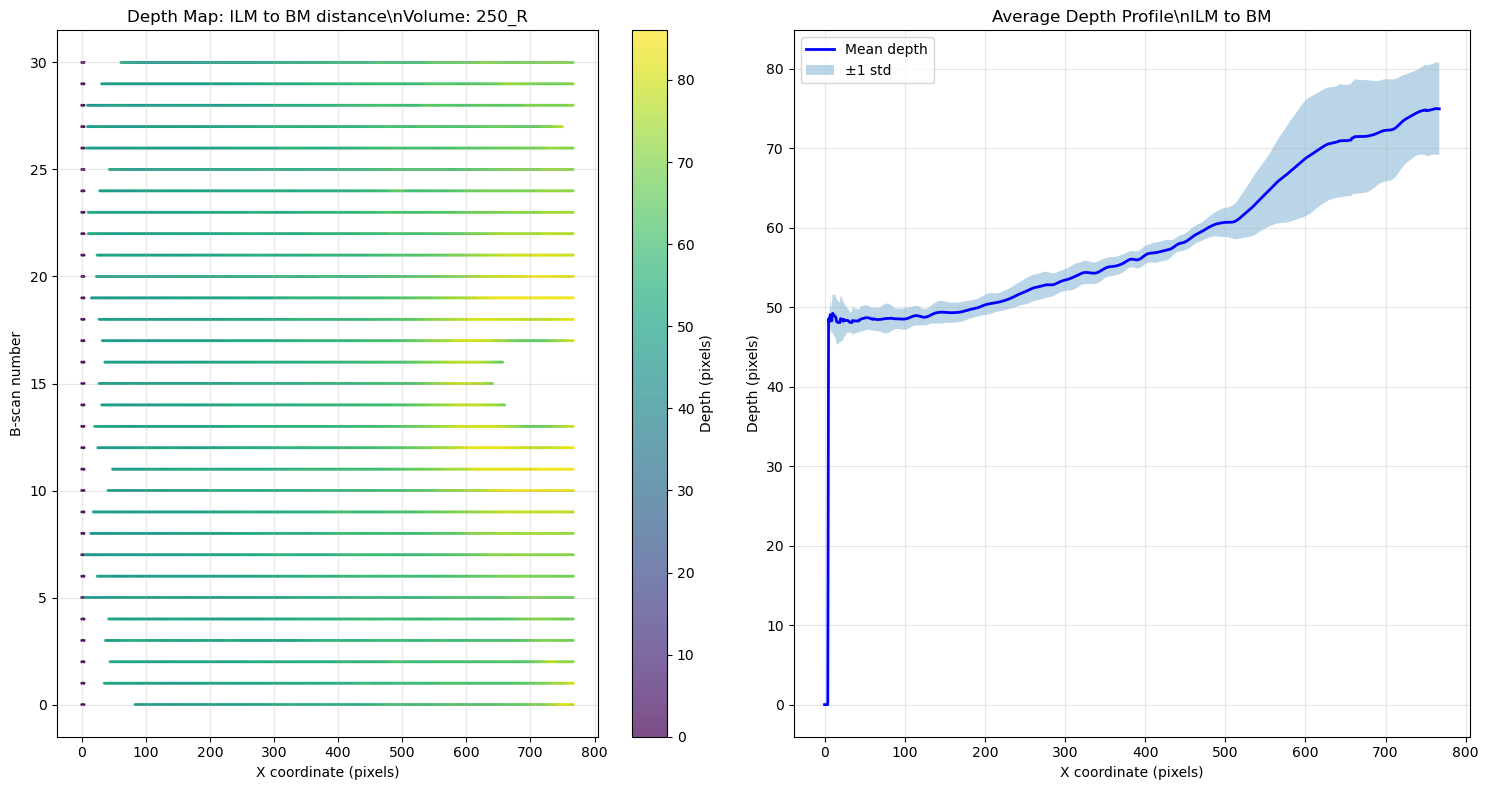

\nDepth Statistics:
Valid measurements: 22,739
Mean depth: 58.11 ± 10.55 pixels
Min depth: 0.00 pixels
Max depth: 86.05 pixels


In [9]:
# List available volumes and layers
volumes = list_available_volumes(names)
print(f"\\nAvailable layers: {list(layers.keys())}")

# Create depth map for ILM to BM distance
print("\\n" + "="*50)
print("Creating depth map: ILM to BM")
print("="*50)
depth_matrix_ilm_bm = create_depth_map(images, layers, names, "250_R", 
                                       layer1='ILM', layer2='BM',
                                       save_path="depth_map_ILM_BM.png")

Plotting sample image with layer annotations


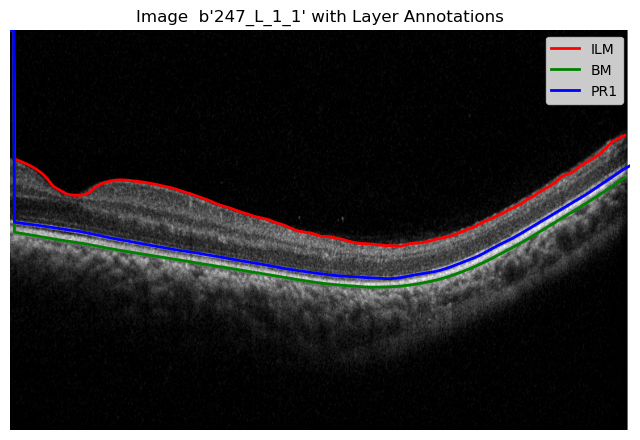

In [12]:
# Plot a sample image with ILM and BM layer annotations from the same volume
print("="*50)
print("Plotting sample image with layer annotations")
print("="*50)   
# Plot image 0 with ILM, BM, and PR1 layer annotations  

img0 = images[45]

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img0, cmap='gray')
ax.set_title(f'Image  {names[45]} with Layer Annotations')
ax.axis('off')

for layer_name, color in zip(['ILM', 'BM', 'PR1'], ['r', 'g', 'b']):
    coords = layers[layer_name][45]  # shape: (width,) or (width, 2)
    if coords.ndim == 1:
        # If only y-coordinates, x is just np.arange
        x = np.arange(coords.shape[0])
        y = coords
    else:
        # If (x, y) pairs
        x, y = coords[:, 0], coords[:, 1]
    ax.plot(x, y, color=color, label=layer_name, linewidth=2)

ax.legend()
plt.show()